In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import mlflow
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import shap
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [26]:
# Leitura do dataset refinado
diretorio_acidentes = 'data/refined/acidentes_recife_normalizado.csv'
df_acidentes = pd.read_csv(diretorio_acidentes, sep=',', parse_dates=['data'], index_col=0)
       

In [27]:
duplicatas = df_acidentes.duplicated(keep=False)

numero_duplicatas = duplicatas.sum()

# Mostrar o número de duplicatas
print(f'Número de registros duplicados existentes: {numero_duplicatas}')

Número de registros duplicados existentes: 0


# Escolhendo coluna para Classificação

In [28]:
df_acidentes.head()

,data,hora,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,Protocolo,natureza,dia_da_semana,mes,ano,estacao,natureza_acidente,mes_ano
6,2020-01-01,04:47:00,FINALIZADA,PINA,AV CONSELHEIRO AGUIAR,NaN,PINA,CHOQUE OBJETO FIXO,AUTO CHOCOU-SE EM MURO DE UMA RESIDENCIA E EM ...,0.111111,0.027507,0.00172,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.000000,NaN,NaN,NaN,Wednesday,1.0,2020.0,Verão,Sem vítimas,2020-01
8,2020-01-01,10:07:00,FINALIZADA,MADALENA,EST DOS REMEDIOS,LADO OPOSTO AO LESSA DE ANDRADE,MADALENA,CHOQUE OBJETO FIXO,PEGEOUT SE CHOCOU COM POSTE E COM O GRADIL DA ...,0.111111,0.027507,0.00172,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.047619,NaN,NaN,NaN,Wednesday,1.0,2020.0,Verão,Não fatal,2020-01
9,2020-01-01,12:09:00,FINALIZADA,NOVA DESCOBERTA,RUA NOVA DESCOBERTA,NaN,NOVA DESCOBERTA,CHOQUE VEÍCULO PARADO,COLISÃO SEM VÍTIMA,0.111111,0.050000,0.00000,0.000000,0.000000,0.000000,0.066667,0.018182,0.000000,0.000000,NaN,NaN,NaN,Wednesday,1.0,2020.0,Verão,Sem vítimas,2020-01
13,2020-01-01,16:56:00,FINALIZADA,SAN MARTIN,RUA VINTE E UM DE ABRIL,LOJA MULTILAR,SAN MARTIN,ABALROAMENTO TRANSVERSAL,COLISÃO S/VITIMAS UMA MOTO E UM AUTO,0.111111,0.125000,0.00000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,Wednesday,1.0,2020.0,Verão,Sem vítimas,2020-01
14,2020-01-01,23:46:00,FINALIZADA,BOA VIAGEM,RUA DEZ DE JULHO,APÓS A ESTAÇÃO AEROPORTO / NA RUA DO SALÃO DE ...,BOA VIAGEM,COLISÃO FRONTAL,ENTRE AUTO E MOTO. C/V,0.111111,0.125000,0.00000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.047619,NaN,NaN,NaN,Wednesday,1.0,2020.0,Verão,Não fatal,2020-01


In [29]:

# Preparação dos dados para um modelo de classificação (natureza_acidente)
df_classificacao = df_acidentes.copy()

# Selecionando as colunas relevantes para classificação
columns_to_drop_classificacao = [
    'data', 'hora', 'endereco', 'complemento', 'bairro_cruzamento',
    'descricao', 'Protocolo', 'estacao', 'vitimas', 'tipo', 'natureza', 'ano', 'mes_ano'
]

df_classificacao = df_classificacao.drop(columns=columns_to_drop_classificacao)

# Remover linhas com valores ausentes na coluna alvo
df_classificacao = df_classificacao.dropna(subset=['natureza_acidente'])

# Tratamento dos valores ausentes (NaNs) nas features
for column in df_classificacao.columns:
    if df_classificacao[column].dtype == 'object':
        df_classificacao[column].fillna(df_classificacao[column].mode()[0], inplace=True)
    else:
        df_classificacao[column].fillna(df_classificacao[column].mean(), inplace=True)

# Convertendo colunas categóricas para numéricas usando Label Encoding
categorical_columns = df_classificacao.select_dtypes(include=['object']).columns
for column in categorical_columns:
    df_classificacao[column] = df_classificacao[column].astype('category').cat.codes


#Estudar trocar Label Encoding por outra técnica - Target Encoding - Olhar a cardinalidade das variáveis categóricas. Se tiver baixa cardinalidade, one hot encoding.   Se fora alta, target encode

In [30]:
df_classificacao.head()

,situacao,bairro,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimasfatais,dia_da_semana,mes,natureza_acidente
6,8,90,0.111111,0.027507,0.00172,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.000428,6,1.0,2
8,8,78,0.111111,0.027507,0.00172,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.000428,6,1.0,1
9,8,85,0.111111,0.050000,0.00000,0.000000,0.000000,0.000000,0.066667,0.018182,0.000000,0.000428,6,1.0,2
13,8,97,0.111111,0.125000,0.00000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000428,6,1.0,2
14,8,17,0.111111,0.125000,0.00000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000428,6,1.0,1


# Separando dados de treinamento, validação e teste.

In [31]:
# Separando os dados em features e target
X_classificacao = df_classificacao.drop(columns=['natureza_acidente'])
y_classificacao = df_classificacao['natureza_acidente']

# Separando os dados em treinamento, validação e teste com amostragem estratificada
X_train, X_temp, y_train, y_temp = train_test_split(X_classificacao, y_classificacao, test_size=0.4, random_state=42, stratify=y_classificacao)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



In [32]:
# Verificar sobreposição de amostras entre conjuntos de treino e teste
overlap_train_test = pd.merge(X_train, X_test, how='inner', indicator=True)
print(f"Número de amostras sobrepostas entre treino e teste: {len(overlap_train_test)}")

Número de amostras sobrepostas entre treino e teste: 41409


# Treinando 4 modelos de classificação.

In [33]:
# Padronizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convertendo de volta para DataFrame para manter os nomes das características
X_train_df = pd.DataFrame(X_train, columns=X_classificacao.columns)
X_val_df = pd.DataFrame(X_val, columns=X_classificacao.columns)
X_test_df = pd.DataFrame(X_test, columns=X_classificacao.columns)

#verificar um possível vazamento de dados

### Logistic Regression

In [34]:
with mlflow.start_run(run_name="Logistic Regression"):
    # Definindo o modelo
    model_lr = LogisticRegression()

    # Treinamento
    model_lr.fit(X_train, y_train)

    # Previsões
    y_pred_val_lr = model_lr.predict(X_val)

    # Avaliação
    accuracy_lr = accuracy_score(y_val, y_pred_val_lr)
    report_lr = classification_report(y_val, y_pred_val_lr, output_dict=True)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy_lr)

    # Log model
    mlflow.sklearn.log_model(model_lr, "model")


In [35]:
# Parâmetros de busca
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2']
}

# Executando GridSearchCV para Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

best_model_lr = grid_search_lr.best_estimator_
print(f"Best Logistic Regression model: {best_model_lr}")
print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Best score: {grid_search_lr.best_score_}")

# Avaliar o melhor modelo no conjunto de teste
y_pred_test_lr = best_model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_test_lr)
print(f"Test accuracy for Logistic Regression: {accuracy_lr}")

# Registrando o nome do melhor modelo no MlFlow
with mlflow.start_run(run_name="Best Model - Logistic Regression"):
    mlflow.log_metric("test_accuracy", accuracy_lr)
    mlflow.sklearn.log_model(best_model_lr, "best_model")


Best Logistic Regression model: LogisticRegression(C=0.1)
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.958138887930214
Test accuracy for Logistic Regression: 0.9585349901896665


### Decision Tree

In [36]:
with mlflow.start_run(run_name="Decision Tree"):
    # Definindo o modelo
    model_dt = DecisionTreeClassifier()

    # Treinamento
    model_dt.fit(X_train, y_train)

    # Previsões
    y_pred_val_dt = model_dt.predict(X_val)

    # Avaliação
    accuracy_dt = accuracy_score(y_val, y_pred_val_dt)
    report_dt = classification_report(y_val, y_pred_val_dt, output_dict=True)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy_dt)
    
    # Log classification report
    mlflow.log_metrics({
        'precision': report_dt['weighted avg']['precision'],
        'recall': report_dt['weighted avg']['recall'],
        'f1-score': report_dt['weighted avg']['f1-score']
    })

    # Log model
    mlflow.sklearn.log_model(model_dt, "model")


In [37]:
# Parâmetros de busca
param_grid_dt = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Executando GridSearchCV para Decision Tree
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

best_model_dt = grid_search_dt.best_estimator_

# Avaliar o melhor modelo no conjunto de teste
y_pred_test_dt = best_model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_test_dt)
print(f"Test accuracy for Decision Tree: {accuracy_dt}")

# Registrando o nome do melhor modelo no MlFlow
with mlflow.start_run(run_name="Best Model - Decision Tree"):
    mlflow.log_metric("test_accuracy", accuracy_dt)
    mlflow.sklearn.log_model(best_model_dt, "best_model")


Test accuracy for Decision Tree: 0.9584041857423152


### Random Forest

In [38]:
with mlflow.start_run(run_name="Random Forest"):
    # Definindo o modelo
    model_rf = RandomForestClassifier()

    # Treinamento
    model_rf.fit(X_train, y_train)

    # Previsões
    y_pred_val_rf = model_rf.predict(X_val)

    # Avaliação
    accuracy_rf = accuracy_score(y_val, y_pred_val_rf)
    report_rf = classification_report(y_val, y_pred_val_rf, output_dict=True)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy_rf)
    
    # Log classification report
    mlflow.log_metrics({
        'precision': report_rf['weighted avg']['precision'],
        'recall': report_rf['weighted avg']['recall'],
        'f1-score': report_rf['weighted avg']['f1-score']
    })

    # Log model
    mlflow.sklearn.log_model(model_rf, "model")



In [39]:
# Parâmetros de busca
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Executar GridSearchCV para Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_
print(f"Best Random Forest model: {best_model_rf}")
print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best score: {grid_search_rf.best_score_}")

# Avaliar o melhor modelo no conjunto de teste
y_pred_test_rf = best_model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
print(f"Test accuracy for Random Forest: {accuracy_rf}")

# Registrando o nome do melhor modelo no MlFlow
with mlflow.start_run(run_name="Best Model - Random Forest"):
    mlflow.log_metric("test_accuracy", accuracy_rf)
    mlflow.sklearn.log_model(best_model_rf, "best_model")


Best Random Forest model: RandomForestClassifier(max_depth=10, min_samples_split=10)
Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.9590982821719471
Test accuracy for Random Forest: 0.9591890124264225


### Support Vector Machine

In [40]:
with mlflow.start_run(run_name="Support Vector Machine"):
    # Definindo o modelo
    model_svm = SVC()

    # Treinamento
    model_svm.fit(X_train, y_train)

    # Previsões
    y_pred_val_svm = model_svm.predict(X_val)

    # Avaliação
    accuracy_svm = accuracy_score(y_val, y_pred_val_svm)
    report_svm = classification_report(y_val, y_pred_val_svm, output_dict=True)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy_svm)
    
    # Log classification report metrics
    mlflow.log_metrics({
        'precision_weighted': report_svm['weighted avg']['precision'],
        'recall_weighted': report_svm['weighted avg']['recall'],
        'f1_score_weighted': report_svm['weighted avg']['f1-score'],
        'precision_macro': report_svm['macro avg']['precision'],
        'recall_macro': report_svm['macro avg']['recall'],
        'f1_score_macro': report_svm['macro avg']['f1-score']
    })

    # Log model
    mlflow.sklearn.log_model(model_svm, "model")


In [41]:
# Parâmetros de busca
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Executar GridSearchCV para Support Vector Machine
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

best_model_svm = grid_search_svm.best_estimator_
print(f"Best Support Vector Machine model: {best_model_svm}")
print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best score: {grid_search_svm.best_score_}")

# Avaliar o melhor modelo no conjunto de teste
y_pred_test_svm = best_model_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
print(f"Test accuracy for Support Vector Machine: {accuracy_svm}")

# Registrando o nome do melhor modelo no MlFlow
with mlflow.start_run(run_name="Best Model - Support Vector Machine"):
    mlflow.log_metric("test_accuracy", accuracy_svm)
    mlflow.sklearn.log_model(best_model_svm, "best_model")


Best Support Vector Machine model: SVC(C=1)
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9583133128750537
Test accuracy for Support Vector Machine: 0.9578809679529104


In [42]:
#comando feito para inicializar o mlflow no navegador. Descomente quando quiser visualizar no navegador.
#http://localhost:5000/


#!mlflow ui


# Realizar diagnóstico do melhor modelo.

O dataset possui poucos dados, então a acurácia acabou sendo muito elevada, talvez até apresentando overfitting. O modelo que apresentou melhor resultado foi o Random Forest, com score 0.9590982821719471. Vamos realizar um diagnóstico para entender como melhorar a eficácia do modelo.


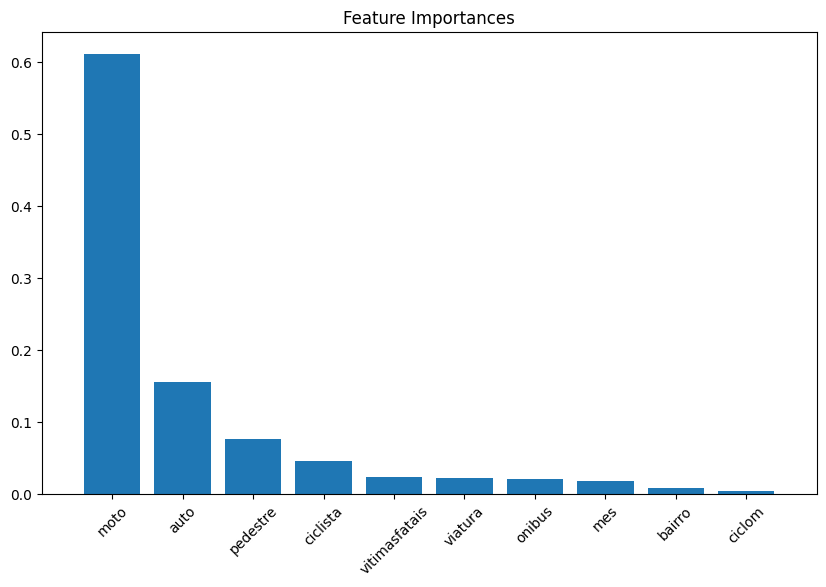

In [49]:
# Feature Importance. É interessante que o rf já possui o feature importance dentro dele
importances = best_model_rf.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices][:10], align="center")
plt.xticks(range(10), [X_classificacao.columns[i] for i in indices][:10], rotation=45)
plt.xlim([-1, 10])
plt.show()

O teste de feature importance mostrou que a coluna 'X' possui uma importância muito alta. Remover ela do modelo pode ser interessante.

In [50]:
# Verificar os nomes das características após a padronização
print("Nomes das características após a padronização:")
print(X_train_df.columns.tolist())

Nomes das características após a padronização:
['situacao', 'bairro', 'auto', 'moto', 'ciclom', 'ciclista', 'pedestre', 'onibus', 'caminhao', 'viatura', 'outros', 'vitimasfatais', 'dia_da_semana', 'mes']


Explicação para a Classe 0


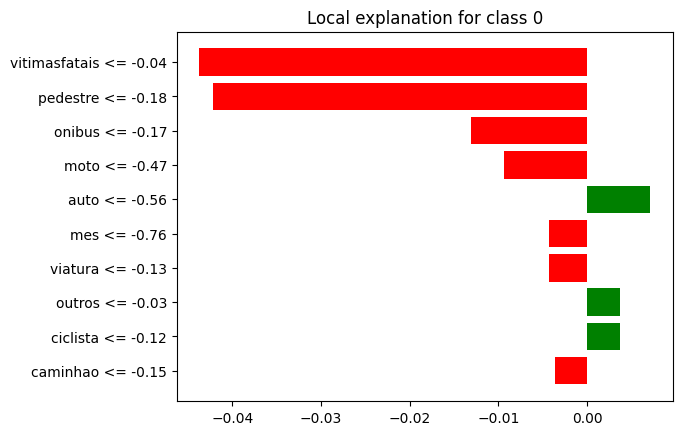

Explicação para a Classe 1


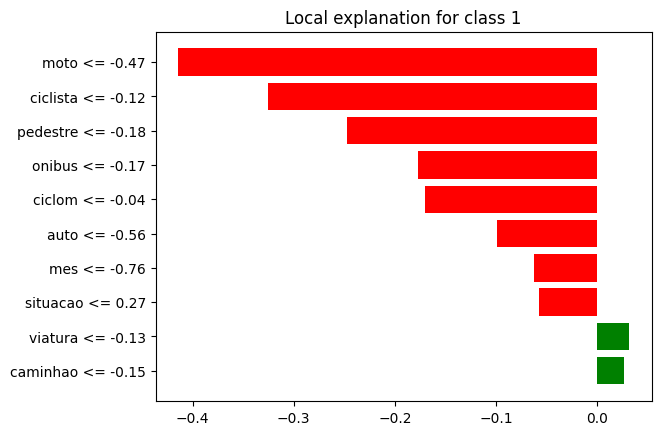

Explicação para a Classe 2


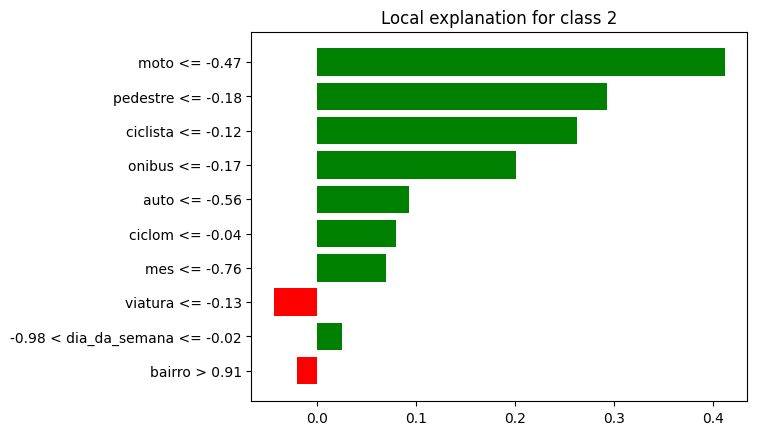

In [58]:
import lime
import lime.lime_tabular

# Criar um explicador LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train, 
    feature_names=X_classificacao.columns, 
    class_names=np.unique(y_classificacao).astype(str), 
    mode='classification'
)

# Função para gerar explicações para diferentes classes
def explain_class(sample_idx, target_class):
    exp = explainer.explain_instance(X_test[sample_idx], best_model_rf.predict_proba, num_features=10, labels=(target_class,))
    fig = exp.as_pyplot_figure(label=target_class)
    fig.patch.set_facecolor('white')
    plt.show()


sample_idx = 0 
for target_class in np.unique(y_classificacao):
    print(f"Explicação para a Classe {target_class}")
    explain_class(sample_idx, target_class)


### A coluna natureza_acidentes possui 3 rótulos. Uma  outra sugestão para melhorar o desempenho do modelo seria transformar os rótulos em binário.

Então, ao invés de termos:
-Sem vítimas
-Não Fatal
-Fatal

Poderíamos simplificar a interpretação do modelo em  apenas 2:
-Não Fatal
-Fatal